<a href="https://colab.research.google.com/github/MatthewTafazoli/Multi-Variate-Time-Series-Prediction-Model/blob/main/Multi_Variate_Time_Series_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Import the relevant packages
# We will be training this model via Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [4]:
# Set the layers of our Recurrent Neural Network (RNN)
# We will be using Long Short-Term Memory (LSTM) for it's ability to process long sequences of data
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(Net, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [5]:
from urllib.request import url2pathname
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, url):
        #TODO
        response = requests.get(url)
        self.download = response.content
        self.series_data = pd.read_csv(io.StringIO(self.download.decode('utf-8')))
        self.series_data.x = self.series_data["x"].replace({"-": None}).astype(float)
        self.series_data.y = self.series_data["y"].replace({"-": None}).astype(float)
        self.seq_len = self.series_data.shape[0]
    def head(self):
        return self.series_data.head()
    def __len__(self):
        #TODO
        return len(self.series_data)
    def __getitem__(self, idx):
        #TODO
        dy = torch.tensor(self.series_data.iloc[idx,0:])
        return self.seq_len, dy

(2000, 3)
<class 'pandas.core.frame.DataFrame'>
(2000, 3)
<class 'pandas.core.frame.DataFrame'>
(2000, 3)
<class 'pandas.core.frame.DataFrame'>
(327, 3)
<class 'pandas.core.frame.DataFrame'>


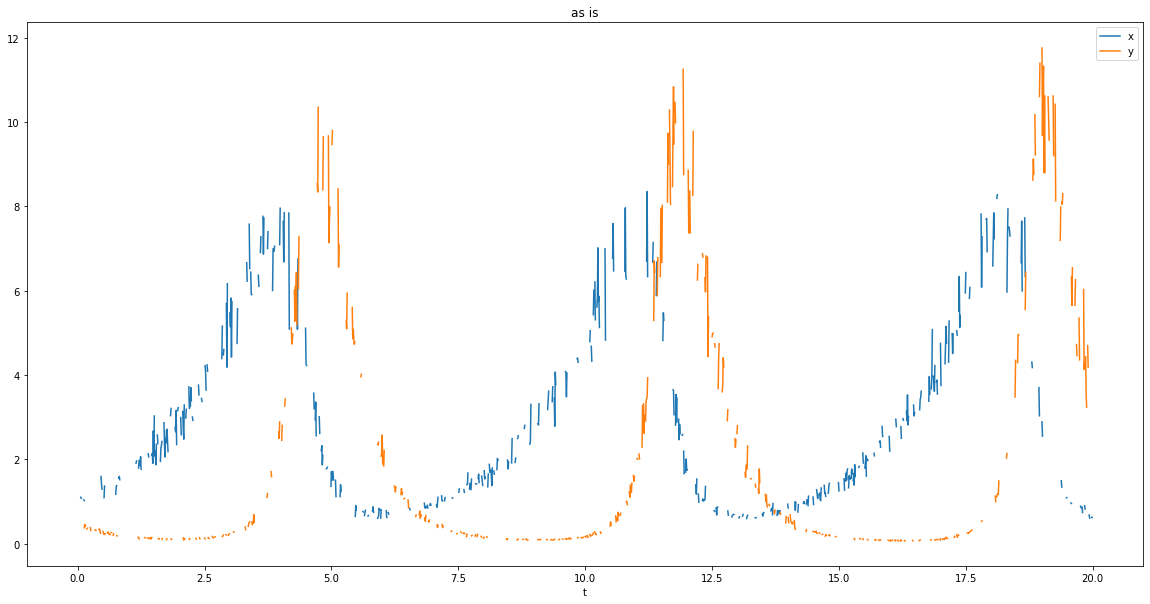

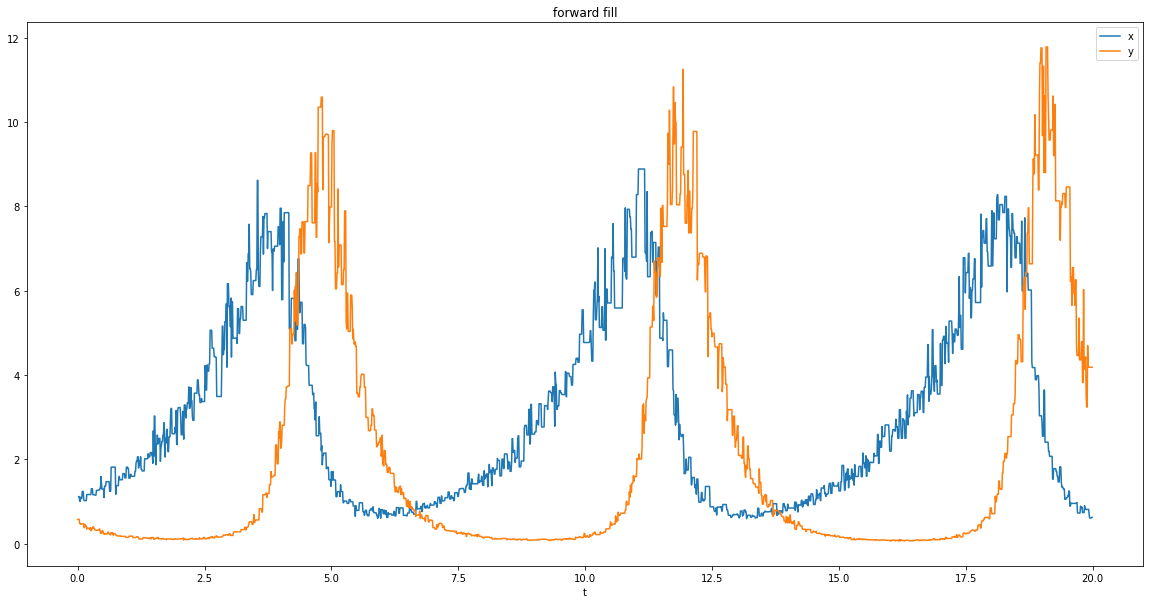

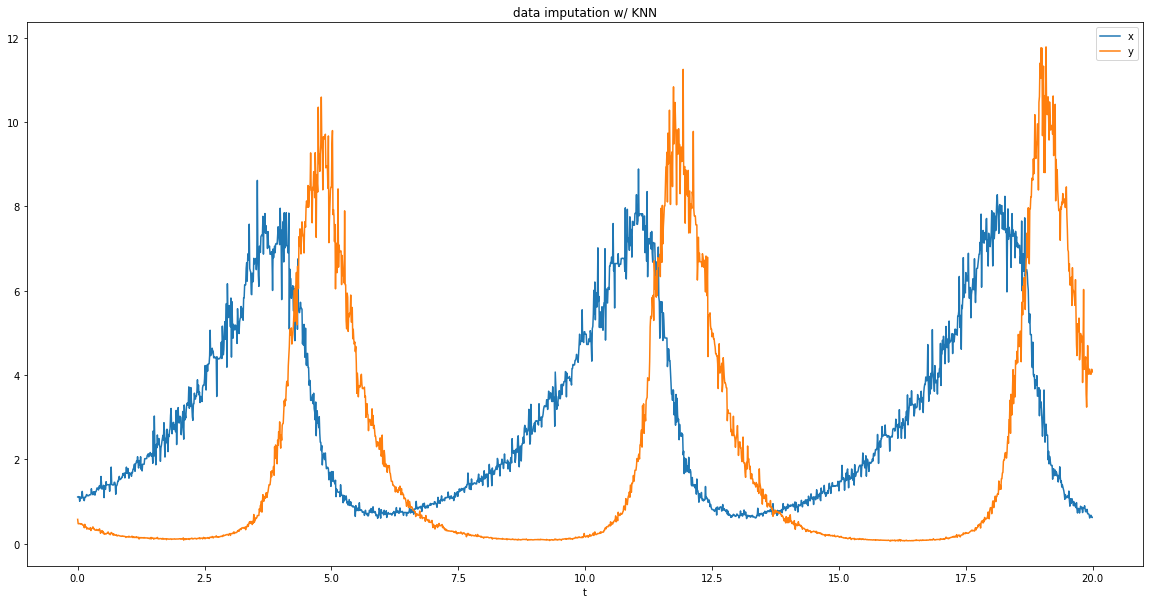

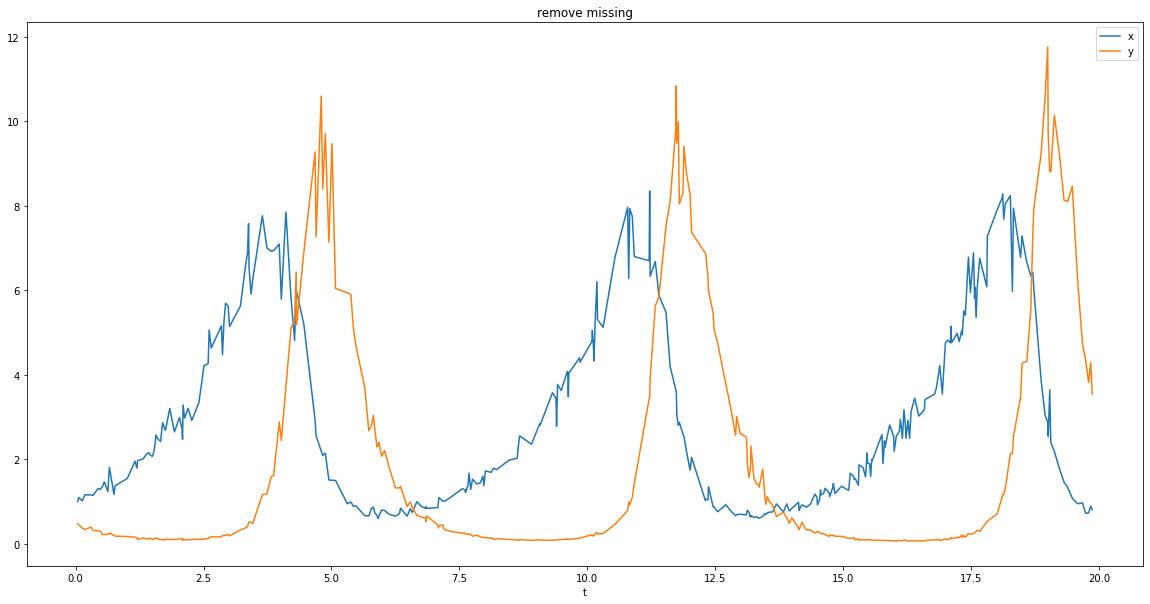

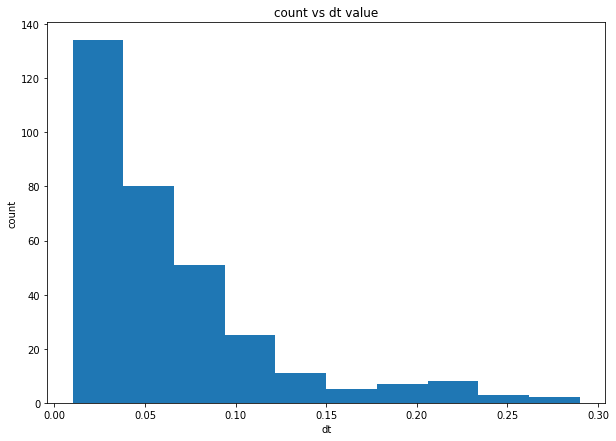

In [8]:
# We download the dataset's csv file
# The dataset is missing many values in both the x and y fields, so we must adjust for that before training
# Three separate methods are used: forward filling the missing x/y values, Sklearn's native data imputation function, and removing the rows with missing x/y values altogether
# We then plot the data points for comparison
from torch.utils.data import TensorDataset, DataLoader

url = "https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv"
dataset = pd.read_csv(url)
print(dataset.shape)
print(type(dataset))

dataset1 = pd.DataFrame(dataset, columns = ['t', 'x', 'y'])
dataset1 = dataset1.replace('-', np.nan)
dataset1 = dataset1.astype(float)
dataset1.plot(x= "t", y=["x", "y"], kind="line", title="as is", figsize=(20, 10))
dataset1 = dataset1.ffill()
print(dataset1.shape)
print(type(dataset1))
dataset1.plot(x= "t", y=["x", "y"], kind="line", title="forward fill", figsize=(20, 10))


imputer = KNNImputer()
dataset2 = pd.read_csv(url, na_values='-')
imputer.fit(dataset2)
dataset2 = imputer.transform(dataset2)
dataset2 = pd.DataFrame(dataset2, columns = ['t', 'x', 'y'])
print(dataset2.shape)
print(type(dataset2))
dataset2.plot(x= "t", y=["x", "y"], kind="line", title="data imputation w/ KNN", figsize=(20, 10))


dataset = dataset.loc[dataset["x"] != "-"]
dataset = dataset.loc[dataset["y"] !=  "-"].values #numpy array of original dataset with null x/y values removed
dataset3 = pd.DataFrame(dataset, columns = ['t', 'x', 'y'])
dataset3 = dataset3.astype(float)
print(dataset3.shape)
print(type(dataset3))
dataset3.plot(x= "t", y=["x", "y"], kind="line", title="remove missing", figsize=(20, 10))


time_steps = []
t = dataset[0][0]

for x in dataset[1:]:
  dt = round(x[0] - t, 3)
  time_steps.append(dt)
  t = x[0]

unique_values = list(set(time_steps)).sort()
time_steps = np.array(time_steps)

dt_value, count = np.unique(time_steps, return_counts=True)
uv = list(zip(dt_value, count))

fig = plt.figure(figsize =(10, 7))
plt.hist(time_steps, bins = unique_values)
plt.xlabel("dt")
plt.ylabel("count")
plt.title("count vs dt value")
plt.show

dataset = np.vstack(dataset).astype(float)
dataset = torch.from_numpy(dataset) #torch tensor of original dataset

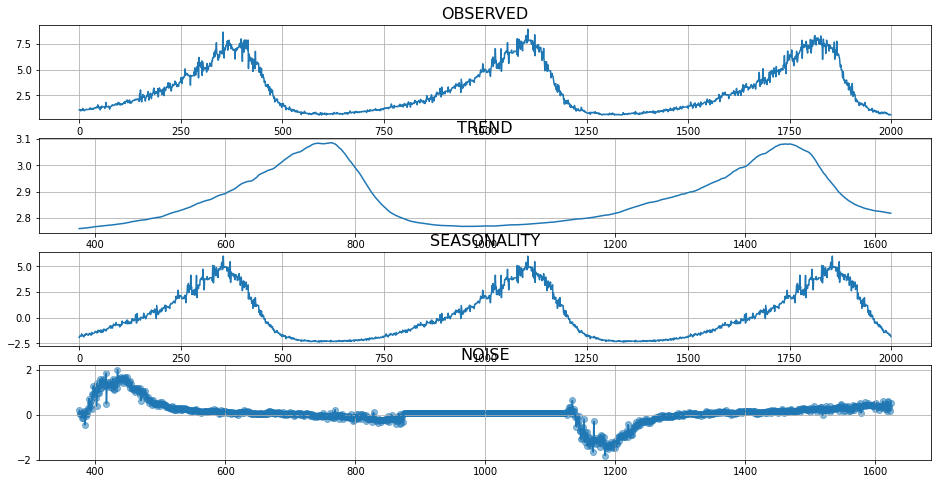

In [9]:
# Check the seasonal decomposition of the data
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_data(df, share_type='x', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

decompose_data(dataset2, samples =  'all', period = 750)

In [10]:
# We set the lookback period of the data, adjust the dataset accordingly, and then split into test/train
# Set a lookback period of 20 for the data (this number was experimented with but didn't lead to large changes in the loss value when training)
# The inputs are x/y values of length *lookback*, with the label being the target directly following that
lookback = 20
inputs = np.zeros((len(dataset2) - lookback, lookback, 2))
labels = np.zeros((len(dataset2) - lookback, 2))

for i in range(lookback, len(dataset2)):
  inputs[i - lookback] = dataset2.iloc[i-lookback:i, 1:]
  labels[i - lookback] = dataset2.iloc[i, 1:]

inputs = inputs.reshape(-1,lookback,2)
labels = labels.reshape(-1,2)

test_portion = int(0.3*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]
display(train_x.shape)
display(train_y.shape)
display(test_x.shape)
display(test_y.shape)

BATCH_SIZE = 32

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

(1386, 20, 2)

(1386, 2)

(594, 20, 2)

(594, 2)

In [11]:
# Initiliaze our model and set the loss function/optimizer
# Mean-Square Error and Adam are both common but powerful choices when training NN's
net = Net(input_dim = 2, hidden_dim = 10, layer_dim = 1, output_dim = 2, dropout_prob = 0)
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
# Functions we can re-use for training/testing our model over the desired amount of epochs
def train_model(data_loader, model, loss_function, optimizer, epoch, train_loss):
  model.train()
  num_batches = len(data_loader)
  total_loss = 0.0

  for X, y in data_loader:
    
    output = model(X.float())
    loss = loss_function(output, y.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  avg_loss = total_loss/num_batches
  train_loss.append(avg_loss)
  if epoch == 0 or (epoch + 1) % 1 == 0:
    print("Train Loss: ", avg_loss)

def test_model(data_loader, model, loss_function, epoch, test_loss):
    model.eval()

    num_batches = len(data_loader)
    total_loss = 0.0

    with torch.no_grad():
        for X, y in data_loader:
            output = model(X.float())
            loss = loss_function(output, y.float())
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    test_loss.append(avg_loss)
    if epoch == 0 or (epoch + 1) % 1 == 0:
      print("Test Loss: ", avg_loss)

In [13]:
# Train our model on the imputed dataset and store the values for plotting later
# After some testing, loss values were found to converge around 75~100 epoch mark
train_loss1 = []
test_loss1 = []
for epoch in range(100):
  if (epoch + 1) % 1 == 0:
    print(f"Epoch # {epoch}\n---------")
  train_model(train_loader, net, loss_function, optimizer, epoch, train_loss1)
  test_model(test_loader, net, loss_function, epoch, test_loss1)
  if (epoch + 1) % 1 == 0:
    print()

print('Finished Training')

Epoch # 0
---------
Train Loss:  11.529855428740035
Test Loss:  13.743636674351162

Epoch # 1
---------
Train Loss:  9.837668995524561
Test Loss:  11.105552762746811

Epoch # 2
---------
Train Loss:  7.323404123616773
Test Loss:  8.394399209154976

Epoch # 3
---------
Train Loss:  5.47716557147891
Test Loss:  6.544774188556605

Epoch # 4
---------
Train Loss:  4.260528298311455
Test Loss:  5.387173271375811

Epoch # 5
---------
Train Loss:  3.470444066579952
Test Loss:  4.500637286472031

Epoch # 6
---------
Train Loss:  2.8227822863778402
Test Loss:  3.7397490638670408

Epoch # 7
---------
Train Loss:  2.2945550874222156
Test Loss:  3.170186400982655

Epoch # 8
---------
Train Loss:  1.9318499967109326
Test Loss:  2.7142082107667296

Epoch # 9
---------
Train Loss:  1.6289902807668197
Test Loss:  2.350159954590102

Epoch # 10
---------
Train Loss:  1.381886035897011
Test Loss:  2.058353462605737

Epoch # 11
---------
Train Loss:  1.1850090622901917
Test Loss:  1.801673193488063

Epoch

In [14]:
#Original is done with dataset2 (dataset filled with Imputation) whereas this is for Dataset1 (just using ffill() to fill dataset)
#Slightly confusing, but despite using dataset1, this is second dataset I am testing so I am labeling everything with "2" in this code block
dataset1 = dataset1.bfill()
inputs2 = np.zeros((len(dataset1) - lookback, lookback, 2))
labels2 = np.zeros((len(dataset1) - lookback, 2))

for i in range(lookback, len(dataset1)):
  inputs2[i - lookback] = dataset1.iloc[i-lookback:i, 1:]
  labels2[i - lookback] = dataset1.iloc[i, 1:]

inputs2 = inputs2.reshape(-1,lookback,2)
labels2 = labels2.reshape(-1,2)

test_portion2 = int(0.3*len(inputs2))
train_x2 = inputs2[:-test_portion2]
train_y2 = labels2[:-test_portion2]
test_x2 = inputs2[-test_portion2:]
test_y2 = labels2[-test_portion2:]

train_data2 = TensorDataset(torch.from_numpy(train_x2), torch.from_numpy(train_y2))
train_loader2 = DataLoader(train_data2, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

test_data2 = TensorDataset(torch.from_numpy(test_x2), torch.from_numpy(test_y2))
test_loader2 = DataLoader(test_data2, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

net2 = Net(input_dim = 2, hidden_dim = 10, layer_dim = 1, output_dim = 2, dropout_prob = 0)
loss_function2 = nn.MSELoss()
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.5)

train_loss2 = []
test_loss2 = []

for epoch in range(100):
  if (epoch + 1) % 1 == 0:
    print(f"Epoch # {epoch}\n---------")
  train_model(train_loader2, net2, loss_function2, optimizer2, epoch, train_loss2)
  test_model(test_loader2, net2, loss_function2, epoch, test_loss2)
  if (epoch + 1) % 1 == 0:
    print()

Epoch # 0
---------
Train Loss:  12.453869963801184
Test Loss:  14.201248510016335

Epoch # 1
---------
Train Loss:  10.307408687680267
Test Loss:  12.03647597754995

Epoch # 2
---------
Train Loss:  8.607193603072055
Test Loss:  10.236886241783699

Epoch # 3
---------
Train Loss:  7.1392648719077885
Test Loss:  8.637601421835521

Epoch # 4
---------
Train Loss:  5.927462533462879
Test Loss:  7.226951730748017

Epoch # 5
---------
Train Loss:  4.893908212351245
Test Loss:  6.061436270674069

Epoch # 6
---------
Train Loss:  4.084294380143631
Test Loss:  5.086436656614144

Epoch # 7
---------
Train Loss:  3.415460314861564
Test Loss:  4.24844957018892

Epoch # 8
---------
Train Loss:  2.844174867452577
Test Loss:  3.5304996822443275

Epoch # 9
---------
Train Loss:  2.347081968950671
Test Loss:  2.9317845731145806

Epoch # 10
---------
Train Loss:  1.913160774596902
Test Loss:  2.437415408384469

Epoch # 11
---------
Train Loss:  1.5643154313397962
Test Loss:  2.03178286842174

Epoch # 

In [15]:
#Dataset3 is a far smaller dataset because every row with either missing x or y is removed. Due to this the time steps are non-uniform, so time is added as a third parameter
inputs3 = np.zeros((len(dataset3) - lookback, lookback, 3))
labels3 = np.zeros((len(dataset3) - lookback, 3))

for i in range(lookback, len(dataset3)):
  inputs3[i - lookback] = dataset3.iloc[i - lookback:i, :]
  labels3[i - lookback] = dataset3.iloc[i, :]

inputs3 = inputs3.reshape(-1,lookback,3)
labels3 = labels3.reshape(-1,3)

test_portion3 = int(0.3*len(inputs3))
train_x3 = inputs3[:-test_portion3]
train_y3 = labels3[:-test_portion3]
test_x3 = inputs3[-test_portion3:]
test_y3 = labels3[-test_portion3:]

train_data3 = TensorDataset(torch.from_numpy(train_x3), torch.from_numpy(train_y3))
train_loader3 = DataLoader(train_data3, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

test_data3 = TensorDataset(torch.from_numpy(test_x3), torch.from_numpy(test_y3))
test_loader3 = DataLoader(test_data3, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

net3 = Net(input_dim = 3, hidden_dim = 10, layer_dim = 1, output_dim = 3, dropout_prob = 0)
loss_function3 = nn.MSELoss()
optimizer3 = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

train_loss3 = []
test_loss3 = []

for epoch in range(100):
  if (epoch + 1) % 1 == 0:
    print(f"Epoch # {epoch}\n---------")
  train_model(train_loader3, net3, loss_function3, optimizer3, epoch, train_loss3)
  test_model(test_loader3, net3, loss_function3, epoch, test_loss3)
  if (epoch + 1) % 1 == 0:
    print()

Epoch # 0
---------
Train Loss:  38.7400697072347
Test Loss:  96.37667846679688

Epoch # 1
---------
Train Loss:  34.1481024424235
Test Loss:  91.3412094116211

Epoch # 2
---------
Train Loss:  31.41630681355794
Test Loss:  84.79181671142578

Epoch # 3
---------
Train Loss:  27.011346181233723
Test Loss:  74.63804626464844

Epoch # 4
---------
Train Loss:  22.709610303243
Test Loss:  65.77768135070801

Epoch # 5
---------
Train Loss:  19.42166010538737
Test Loss:  57.181053161621094

Epoch # 6
---------
Train Loss:  16.159332593282063
Test Loss:  49.210594177246094

Epoch # 7
---------
Train Loss:  13.281359354654947
Test Loss:  42.925262451171875

Epoch # 8
---------
Train Loss:  11.897574106852213
Test Loss:  37.844852447509766

Epoch # 9
---------
Train Loss:  10.393510182698568
Test Loss:  33.71909523010254

Epoch # 10
---------
Train Loss:  9.763061920801798
Test Loss:  30.486559867858887

Epoch # 11
---------
Train Loss:  8.866521120071411
Test Loss:  28.057541847229004

Epoch # 

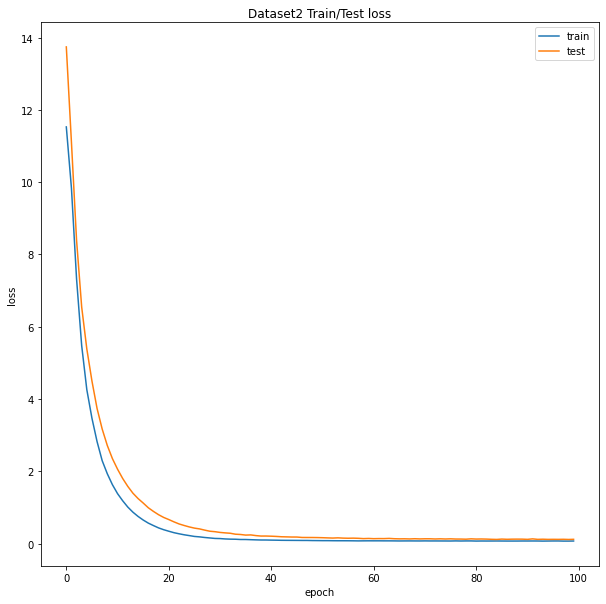

In [16]:
# Plot the Train and Test loss for Imputed dataset
fig = plt.figure(figsize=(10,10)) 
plt.plot(train_loss1)
plt.plot(test_loss1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Dataset2 Train/Test loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

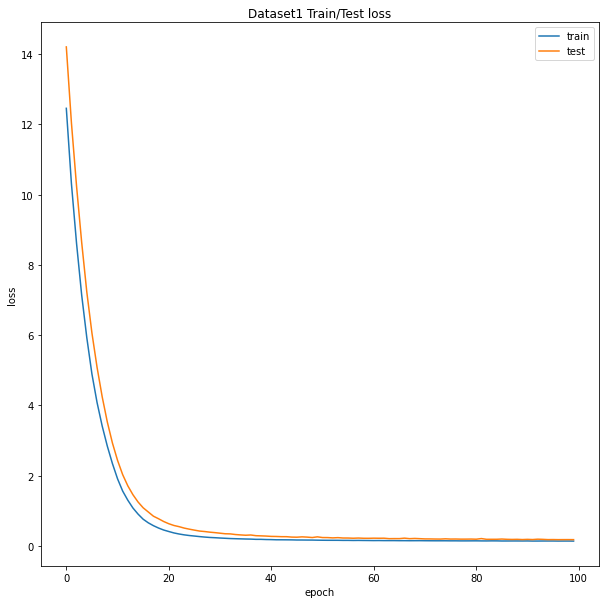

In [17]:
# Train/Test Loss for forward filled dataset
fig = plt.figure(figsize=(10,10)) 
plt.plot(train_loss2)
plt.plot(test_loss2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Dataset1 Train/Test loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

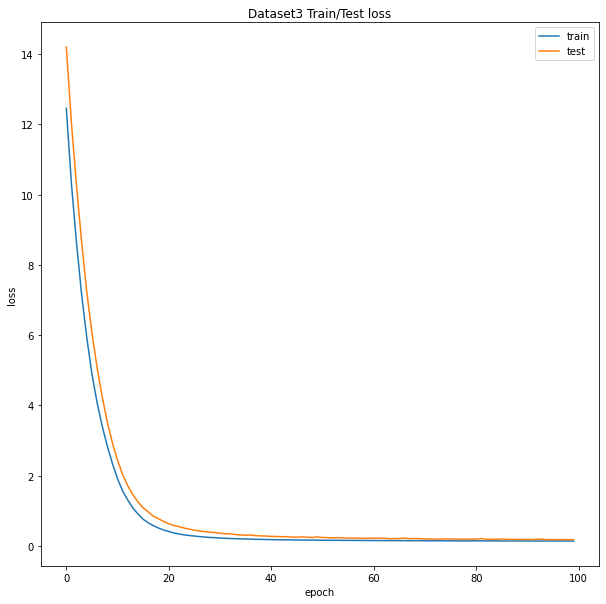

In [19]:
# Train/Test Loss for dataset with missing values removed
fig = plt.figure(figsize=(10,10)) 
plt.plot(train_loss2)
plt.plot(test_loss2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Dataset3 Train/Test loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

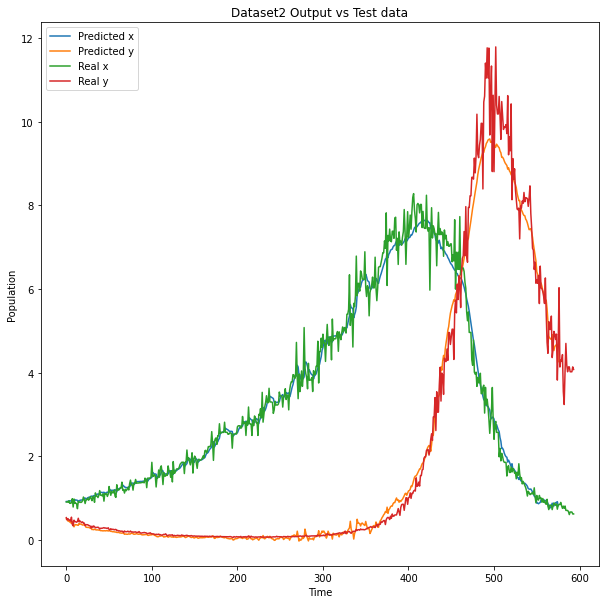

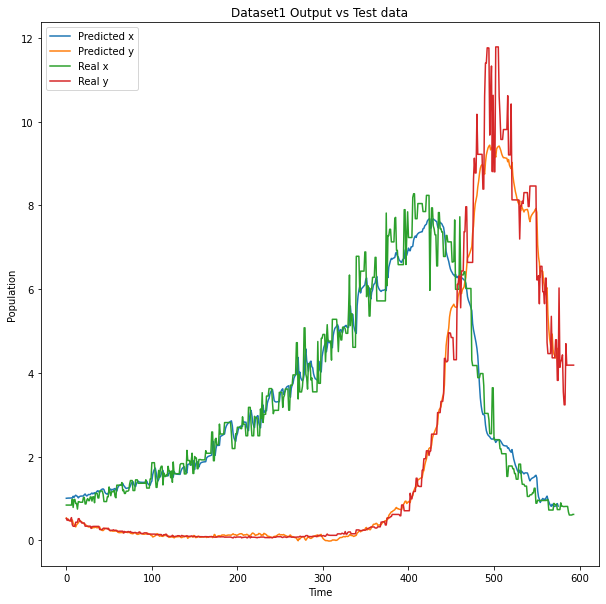

In [20]:
# Store the predicted output values for our Imputed/Forward filled datasets, and then plot them vs training data
# We can see that values matchup quite well over the entirety of our dataset, confirming the acceptable loss values we saw earlier
outputs1 = []
for X, y in test_loader:
  output = net(X.float()).detach().numpy()
  output = output.tolist()
  for i in output:
    outputs1.append(i)

outputs2 = []
for X, y in test_loader2:
  output = net2(X.float()).detach().numpy()
  output = output.tolist()
  for i in output:
    outputs2.append(i)

fig = plt.figure(figsize=(10,10)) 
plt.plot(outputs1)
plt.plot(test_y)
plt.ylabel('Population')
plt.xlabel('Time')
plt.title('Dataset2 Output vs Test data')
plt.legend(['Predicted x', 'Predicted y', 'Real x', 'Real y'], loc='upper left')
plt.show()

fig = plt.figure(figsize=(10,10)) 
plt.plot(outputs2)
plt.plot(test_y2)
plt.ylabel('Population')
plt.xlabel('Time')
plt.title('Dataset1 Output vs Test data')
plt.legend(['Predicted x', 'Predicted y', 'Real x', 'Real y'], loc='upper left')
plt.show()